In [ ]:
### https://pytorch.org/audio/stable/tutorials/speech_recognition_pipeline_tutorial.html
### https://arxiv.org/abs/2006.11477 paper

In [3]:
from torch import nn
import numpy as np
from torch import Tensor
import torch
import torchaudio
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
import os
import soundfile
from torch.utils.data import DataLoader, random_split
torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device, torchaudio.list_audio_backends())
TRAIN_DIR = './data/train/binary_classification/yes_no/'

cuda ['soundfile']


In [19]:
# loading data to dataset:
class SoundDataset(Dataset):

    def __init__(self, directory, gpu):
        self.directory = directory
        self.classes = os.listdir(directory)
        self.gpu = gpu
        self.class_to_num = {cl : i for i, cl in enumerate(self.classes)}
        self.num_to_class = {i : cl for i, cl in enumerate(self.classes)}
        paths = []
        for cl in self.classes:
            tmp = [os.path.join(directory+cl, path) for path in os.listdir(directory + cl)]
            paths+=tmp
        self.paths = paths
    
    
    def __len__(self):
        
        return len(self.paths)
    
    def __getitem__(self, index):
        audio_sample_path = self.paths[index]
        label = self.paths[index].split('/')[-1].split('\\')[0]

        signal, sr = torchaudio.load(audio_sample_path, format = 'wav')
        signal = signal[0]
        if self.gpu:
            signal.to(device)
        
        label_numeric = self.class_to_num[label]
        label_tensor = torch.tensor(label_numeric)
        one_hot_tensor = nn.functional.one_hot(label_tensor, num_classes = len(self.classes))
        one_hot_tensor.to(device)
        return signal, one_hot_tensor
        
        

In [20]:
dataset = SoundDataset(TRAIN_DIR, True)
train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle=True)
validation_dataset = DataLoader(validation_dataset, batch_size = 64, shuffle=True)

In [129]:
bundle = torchaudio.pipelines.WAV2VEC2_BASE #WAV2VEC2_ASR_BASE_960H 
model = bundle.get_model().to(device)
model

Wav2Vec2Model(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      )
      (1-4): 4 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (5-6): 2 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
    )
  )
  (encoder): Encoder(
    (feature_projection): FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (pos_conv_embed): ConvolutionalPositionalEmbedding(
        (conv): ParametrizedConv1d(
          768, 768, kernel_size=(128,), stride=(1,), padding=(64,), groups=16
          (parametriza

In [102]:
waveform = dataset[0][0].to(device)
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

In [115]:
model(waveform)[0].cpu().detach().numpy().shape

(1, 49, 768)

In [104]:
features = [tensor.cpu() for tensor in features]

In [105]:
np.array(features).shape

(12, 1, 49, 768)

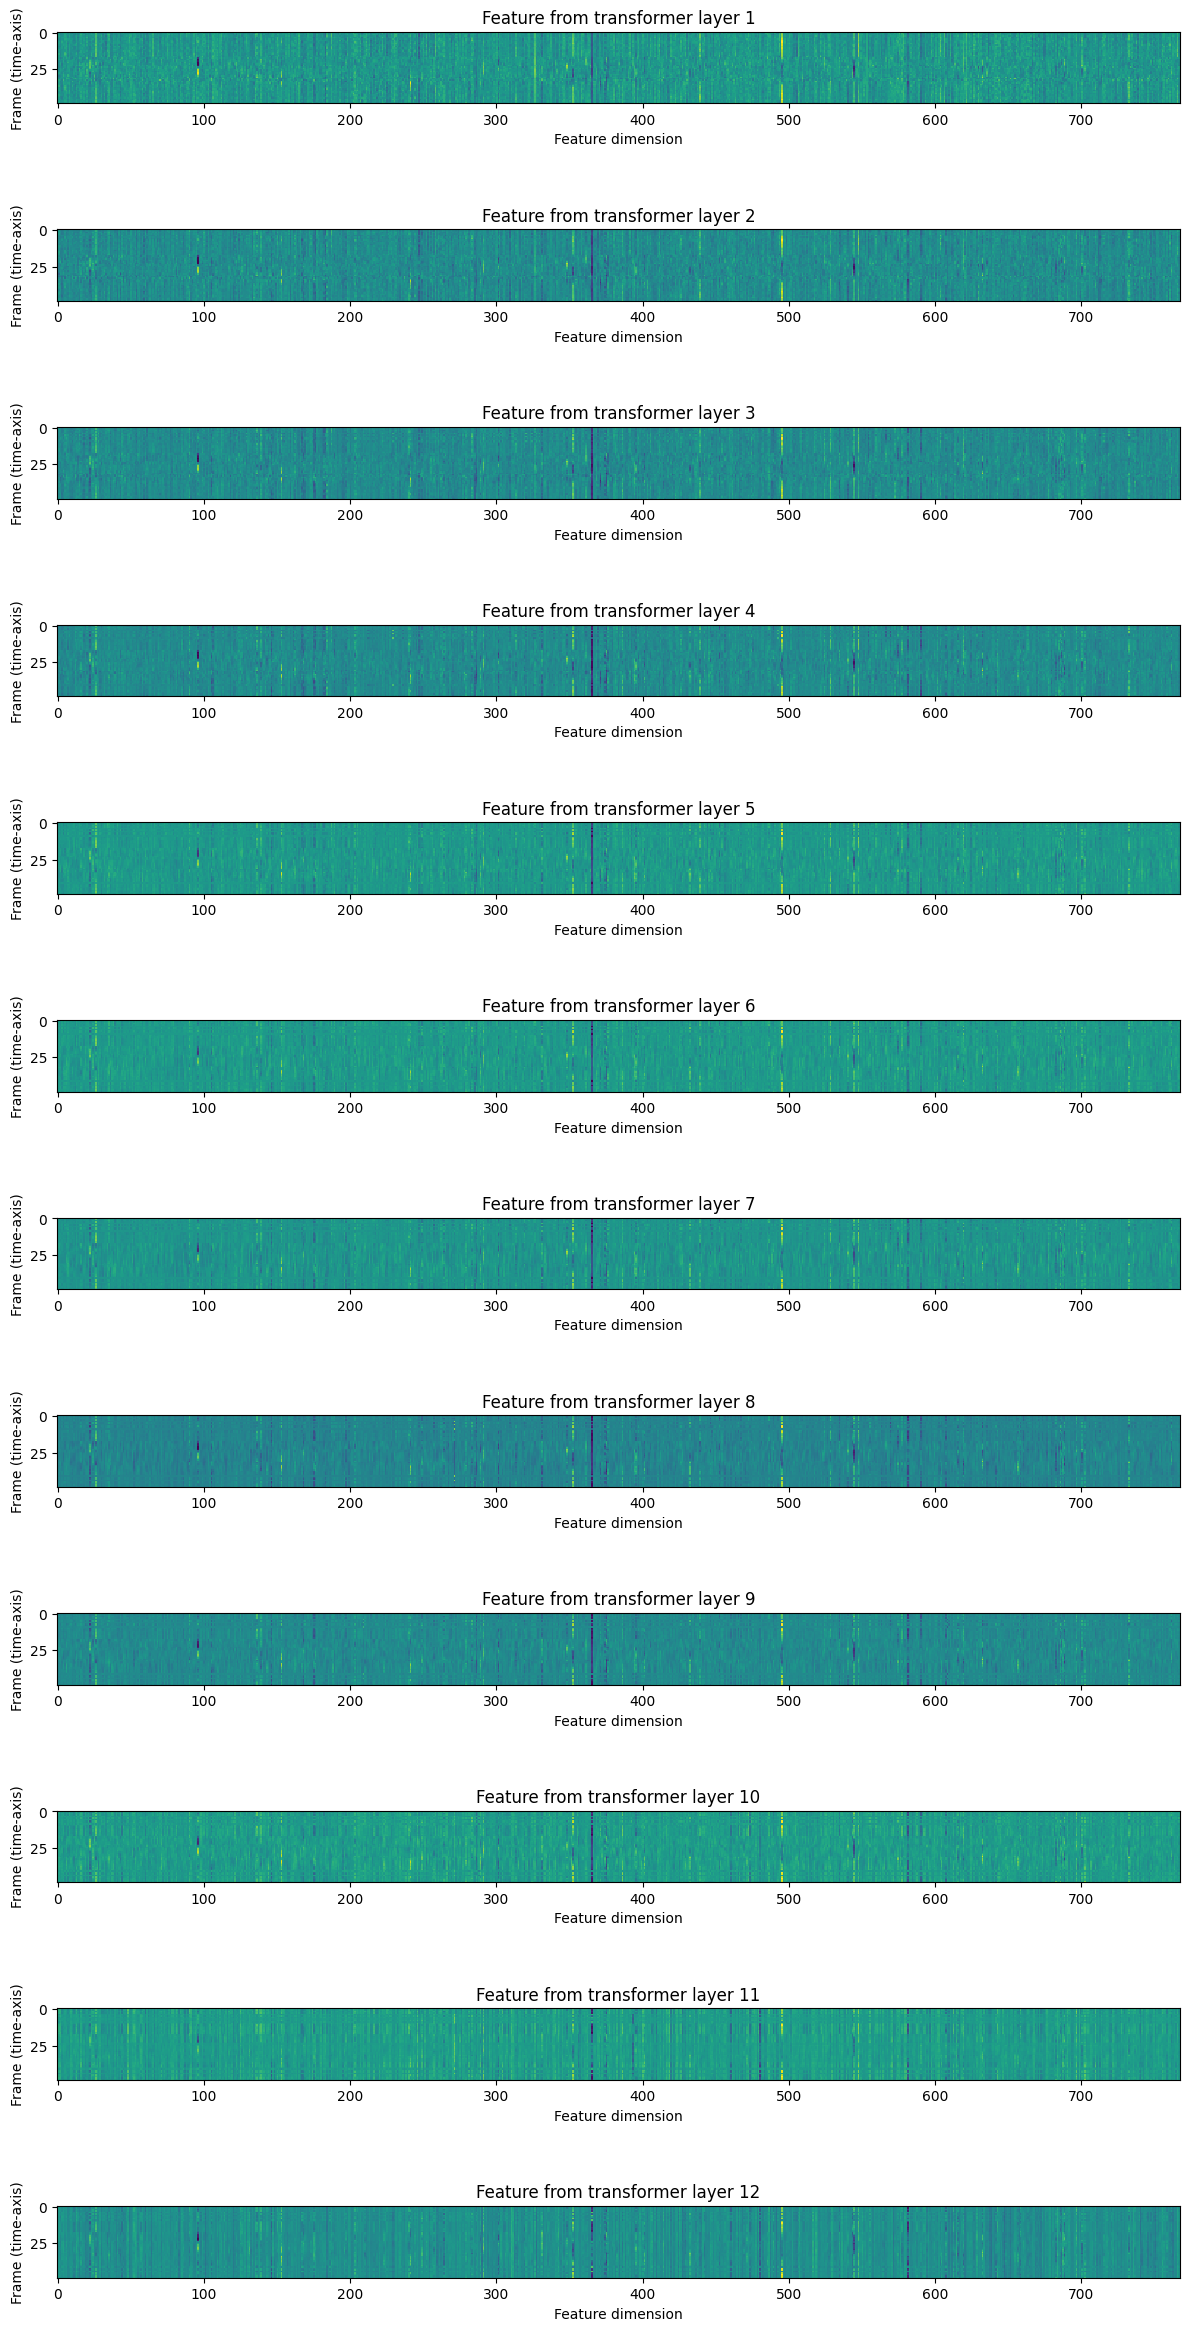

In [63]:
fig, ax = plt.subplots(len(features), 1, figsize=(12, 2 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

In [33]:
class Wav2Vec2ClassificationModel(nn.Module):
    def __init__(self, num_labels, hidden_size, final_dropout = 0.1):
        super().__init__()
        self.base_model = torchaudio.pipelines.WAV2VEC2_BASE.get_model().to(device)
        self.classification_head = Wav2Vec2ClassificationHead(num_labels, hidden_size, final_dropout)
        for param in self.base_model.feature_extractor.parameters():
                param.requires_grad = False

    def forward(self, inputs):
        # Get features from the base model
        features = self.base_model(inputs)[0]

        # Pass features through the classification head
        logits = self.classification_head(features)

        return logits
    

    def train_model(self, train_loader, val_loader, criterion, optimizer, num_epochs=10):
        for epoch in range(num_epochs):
            self.train()  # Set model to training mode
            for i, (batch_inputs, batch_labels) in enumerate(train_loader):
                optimizer.zero_grad()
                outputs = self(batch_inputs.to(device))
                batch_labels = batch_labels.to(device)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()
                print(f'batch number {i}/{len(train_loader)}', end = '\r')

            # Validation
            self.eval()  # Set model to evaluation mode
            with torch.no_grad():
                total_correct = 0
                total_samples = 0
                for val_batch_inputs, val_batch_labels in val_loader:
                    val_outputs = self(val_batch_inputs)
                    _, predicted = torch.max(val_outputs, 1)
                    total_correct += (predicted == val_batch_labels).sum().item()
                    total_samples += val_batch_labels.size(0)
                accuracy = total_correct / total_samples

            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Validation Accuracy: {accuracy}')


class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, num_labels, hidden_size, final_dropout):
        super().__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(final_dropout)
        self.out_proj = nn.Linear(hidden_size, num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

In [34]:
model = Wav2Vec2ClassificationModel(num_labels=2, hidden_size=768, final_dropout=0.1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=64)

# Train the model
model.train_model(train_loader, val_loader, criterion, optimizer, num_epochs=3)

In [122]:
for i, (batch_inputs, batch_labels) in enumerate(train_loader):
    if i>0:
        break